In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from collections import defaultdict
from collections import  Counter



In [5]:
# Helper Functions, run first

def get_hotel_links(ta_link, n_hotels):
  url = ta_link
  page = requests.get(url)
  page_soup =  BeautifulSoup(page.text, 'html.parser')
  links = page_soup.find_all(class_="property_title prominent ")
  hotel_links = []
  for link in links[:(n_hotels)]:
    hotel_links.append("https://www.tripadvisor.com" + link['href'])
  return hotel_links


def get_review_links(hotel_link, n_pages):
  url = hotel_link
  url_list = [hotel_link]
  for i in range(5,(5*(n_pages-1)+1),5):
    splits = url.split('-')
    splits.insert(splits.index('Reviews'), f'or{str(i)}')
    new_url = '-'.join(splits)
    url_list.append(new_url)
  return (url_list)

def get_ratings(link):
  base_url = link
  page = requests.get(base_url)
  page_soup =  BeautifulSoup(page.text, 'html.parser')
  ratings = page_soup.find_all(class_ = 'nf9vGX55')
  review_ratings = []
  for rating in ratings:
    bubbles = rating.find('span')['class'][1]
    if bubbles == 'bubble_10':
      review_rating = 1
    if bubbles == 'bubble_20':
      review_rating = 2
    if bubbles == 'bubble_30':
      review_rating = 3
    if bubbles == 'bubble_40':
      review_rating = 4
    if bubbles == 'bubble_50':
      review_rating = 5
    review_ratings.append(review_rating)
  return review_ratings


def get_dates(link):
  base_url = link
  page = requests.get(base_url)
  page_soup =  BeautifulSoup(page.text, 'html.parser')
  dates = page_soup.find_all(class_ = '_2fxQ4TOx')
  review_dates = []
  for date in dates:
    if date.text[-5:] == 'Today':
      today = datetime.date(datetime.now())
      review_date = (today.strftime('%b %Y'))
    elif date.text[-9:] == 'Yesterday':
      today = datetime.date(datetime.now())
      yesterday = today - timedelta(days = 1)
      review_date = (yesterday.strftime('%b %Y'))
    elif 'ew' in date.text[-8:]:
      today = datetime.date(datetime.now())
      review_date = (today.strftime('%b %Y'))
    else:
      review_date = date.text[-8:]
    review_dates.append(review_date)
  return review_dates

def get_texts(link):
  base_url = link
  page = requests.get(base_url)
  page_soup =  BeautifulSoup(page.text, 'html.parser')
  reviews = page_soup.find_all(class_ = 'oETBfkHU')
  review_texts = []
  for review in reviews:
    text = review.find(class_ = "IRsGHoPm")
    review_texts.append(text.text)
  return review_texts

def get_data(link):
  ratings = get_ratings(link)
  texts = get_texts(link)
  dates = get_dates(link)
  review_dict = {'rating': [], 'text': [], 'date': []}
  for tup in zip(ratings,texts,dates):
    review_dict['rating'].append(tup[0])
    review_dict['text'].append(tup[1])
    review_dict['date'].append(tup[2])

  df = pd.DataFrame()
  df = df.from_dict(review_dict)
  return df

In [6]:
# Main Function
def get_review_data(city,link,n_hotels=5,n_pages=2):
  '''
  Pulls review data from Trip Advisor to return a dataframe with columns
  'rating', 'text', 'date' & 'area'

  Parameters:
  city(str): label for 'area' column
  link(str): trip advisor city search results link 
             (i.e https://www.tripadvisor.com/Hotels-g34059-Wilmington_Delaware-Hotels.html)
  n_hotels(int): number of hotels to get data for (max 30)
  n_pages: number of review pages. (1 page = 5 reviews)
  '''

  hotel_links = get_hotel_links(link, n_hotels)
  print(f'Getting reviews for {len(hotel_links)} hotels')
  city_df = pd.DataFrame({'rating': [], 'text': [], 'date': []})
  for hotel_link in hotel_links:
    print(f'Getting reviews for {hotel_link}')
    review_links = get_review_links(hotel_link, n_pages)
    for review_link in review_links:
      data = get_data(review_link)
      city_df = city_df.append(data)
  city_df['area'] = city
  city_df = city_df[~city_df['text'].str.contains("…")]
  city_df = city_df.reset_index(drop=True)
  return city_df

In [7]:
# test
city = 'philadelphia'
link = 'https://www.tripadvisor.com/Hotels-g60795-Philadelphia_Pennsylvania-Hotels.html'

df=get_review_data(city,link,5,3)

Getting reviews for 5 hotels
Getting reviews for https://www.tripadvisor.com/Hotel_Review-g60795-d115444-Reviews-Philadelphia_Airport_Marriott-Philadelphia_Pennsylvania.html
Getting reviews for https://www.tripadvisor.com/Hotel_Review-g60795-d12416741-Reviews-Aloft_Philadelphia_Downtown-Philadelphia_Pennsylvania.html
Getting reviews for https://www.tripadvisor.com/Hotel_Review-g60795-d122332-Reviews-The_Ritz_Carlton_Philadelphia-Philadelphia_Pennsylvania.html
Getting reviews for https://www.tripadvisor.com/Hotel_Review-g60795-d102463-Reviews-The_Notary_Hotel_Autograph_Collection-Philadelphia_Pennsylvania.html
Getting reviews for https://www.tripadvisor.com/Hotel_Review-g60795-d102542-Reviews-Courtyard_by_Marriott_Philadelphia_Airport-Philadelphia_Pennsylvania.html


In [8]:
df.head()

,rating,text,date,area
0,3.0,Stayed at the Marriott the evening before a mo...,Sep 2020,philadelphia
1,5.0,This was our first trip since Feb 2020. Nervou...,Sep 2020,philadelphia
2,5.0,This is an old school Marriott that could real...,Sep 2020,philadelphia
3,5.0,"Hotel is connected to the airport, short walk....",Aug 2020,philadelphia
4,1.0,I stayed at this hotel for 3 nights. I underst...,Jul 2020,philadelphia


In [9]:
# check for missing values
df.isnull().sum()

rating    0
text      0
date      0
area      0
dtype: int64

In [11]:
# Proprocess data
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

# apply to dataframe
df['text']=df['text'].map(lambda s:preprocess(s)) 
#df['text']=df['text'].map(lambda x:x.split())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
df.head()

,rating,text,date,area
0,3.0,stayed marriott evening morning flight conveni...,Sep 2020,philadelphia
1,5.0,first trip since feb nervous read mixed review...,Sep 2020,philadelphia
2,5.0,old school marriott could really use refresh c...,Sep 2020,philadelphia
3,5.0,hotel connected airport short walk clean room ...,Aug 2020,philadelphia
4,1.0,stayed hotel nights understand cleaning rooms ...,Jul 2020,philadelphia


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


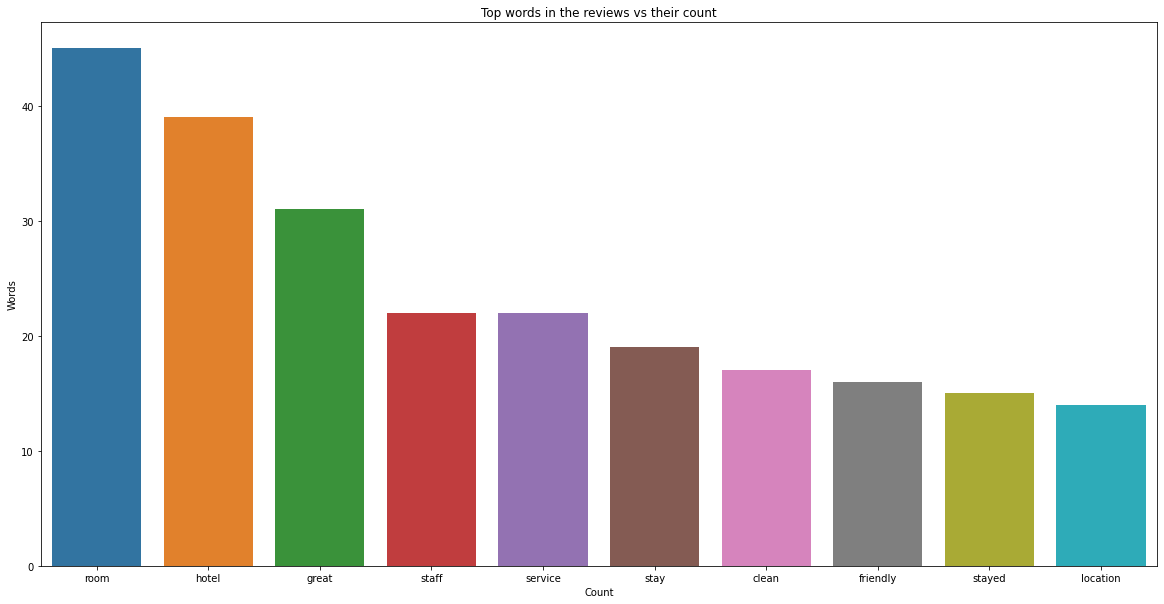

In [31]:
from collections import Counter
from matplotlib import cm
from matplotlib import rcParams
x=Counter(" ".join(df["text"]).split()).most_common(10)
words=[]
counts=[]
for word,count in x:
  words.append(word)
  counts.append(count)
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the reviews vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
sns.barplot(words, counts)


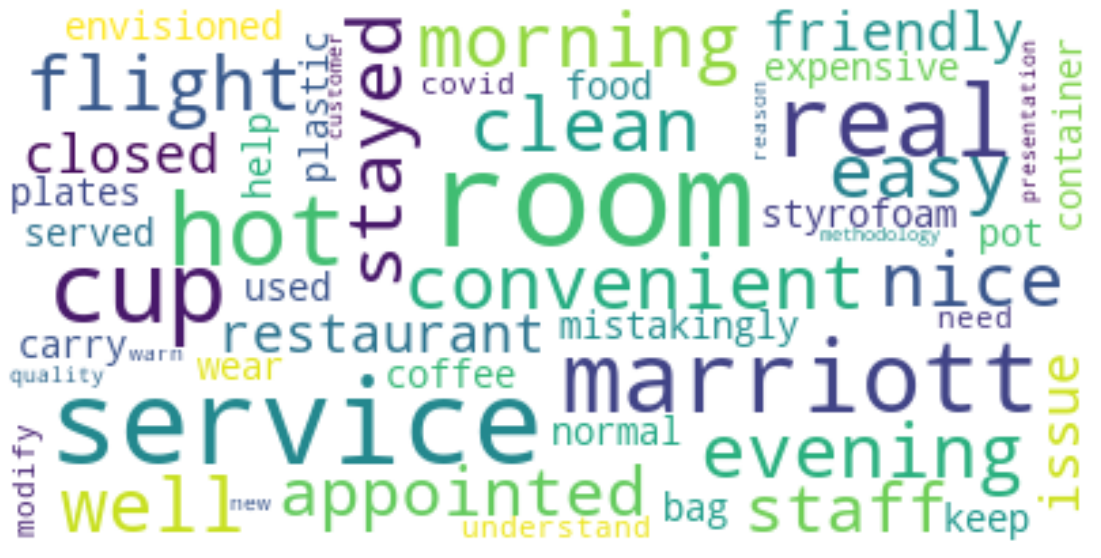

In [33]:
# Start with one review:
text = df.text[0]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
all_reviews=" ".join(review for review in df.text)
print ("There are {} words in the combination of all review.".format(len(all_reviews)))

There are 12368 words in the combination of all review.


'stayed marriott evening morning flight convenient easy room nice clean well appointed staff friendly issue room service restaurant closed mistakingly envisioned normal marriott room service served like carry expensive hot styrofoam container plastic wear bag used get pot coffee cup plates real cups help keep food hot understand covid need modify quality presentation room service real reason warn customer new methodology first trip since feb nervous read mixed reviews friendly check experience clean room delicious hot fresh room service gone better recommend old school marriott could really use refresh customer service great super friendly love still safes item really available upgraded marriotts room clean quiet try stay future without doubt covid seems give places excuses throw customer service wind hotel seem super customer service oriented also plus able plug fire television always option hotel connected airport short walk clean room bathroom good shower pressure great service rent

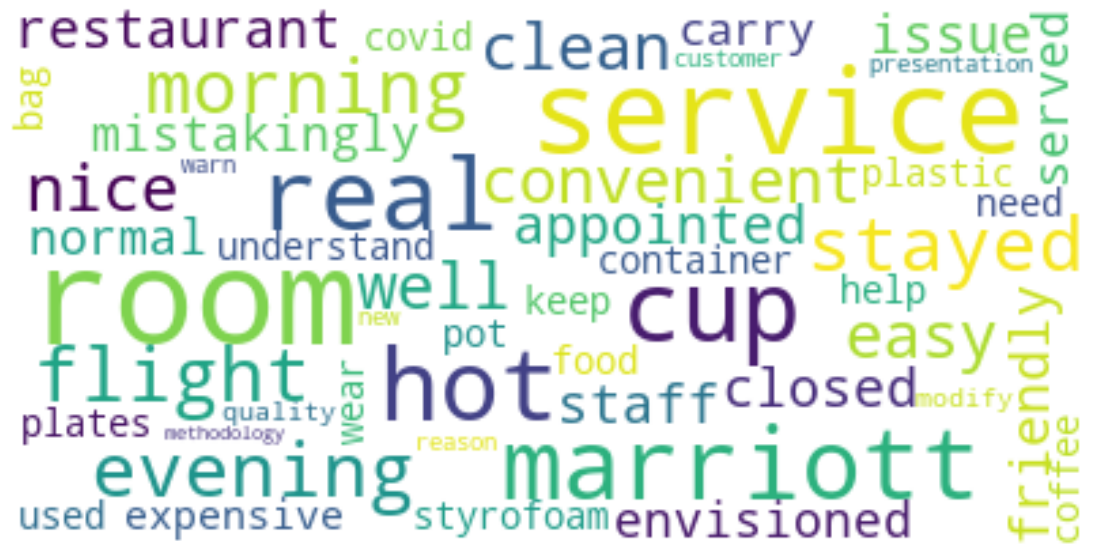

In [39]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df['text'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df.index
df_dtm.head(3)

,able,absolutely,access,accommodating,accommodations,acknowledge,across,actually,added,addition,additional,adjacent,agree,air,aircraft,airport,alarm,aloft,also,although,always,amazing,amenities,anniversary,another,anyone,apart,apologize,appointed,appreciate,area,around,arranged,arrived,aside,ask,asked,assume,assumption,atmosphere,...,walking,walks,want,warm,warn,water,way,weak,wear,wearing,weekend,weeks,welcoming,well,went,wet,whim,wide,wind,window,wine,wiping,wish,within,without,wonderful,work,worked,working,workout,works,worth,would,wound,wrong,wxyz,year,yes,yet,yuk
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title("Top Reviewed words", fontsize=40)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

In [23]:
df_dtm.head(10)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
able,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
absolutely,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
access,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
accommodating,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
accommodations,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acknowledge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
across,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
actually,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
added,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
addition,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Plotting word cloud for each product
#for index,review in enumerate(df_dtm.columns):
generate_wordcloud(df_dtm)

TypeError: ignored